# Churn prediction for an energy company 🔌💡
## Part 2 - Data Exploration and Feature Engineering
### Importing packages and data

Let's start the part 2 of our churn prediction model by importing the `utils` module and loading the cleaned datasets we prepared in the `Churn Prediction - Part 1` notebook. The `utils` module is a custom Python script containing functions we'll use throughout the notebook for data visualization and transformation tasks.

In [1]:
from utils import *

repo_path = "/workspaces/myfolder/energy-churn-prediction"

client_file_path = f"{repo_path}/data/client_data_cleaned.csv"
client_date_cols = ['date_activ', 'date_modif_prod', 'date_renewal', 'date_end']

price_file_path = f"{repo_path}/data/price_data_cleaned.csv"
price_date_col = 'price_date'

# Load the data and convert datetime columns
client_df = load_and_convert_datetime(client_file_path, client_date_cols)
price_df = load_and_convert_datetime(price_file_path, [price_date_col])

### Imputing missing price values 

Let's begin by exploring `price_df`. We'll examine the distinct values of the `price_date` variable and their corresponding frequencies, along with the number of unique IDs in this dataset.

In [2]:
print(f"Number of unique IDs: {price_df['id'].nunique()}")
print("\n------------------------------------------------\n")
print("Distinct values of the 'price_date' variable and corresponding cardinality:")
price_df[price_date_col].value_counts().sort_index()

Number of unique IDs: 16096

------------------------------------------------

Distinct values of the 'price_date' variable and corresponding cardinality:


price_date
2015-01-01    16070
2015-02-01    16082
2015-03-01    16074
2015-04-01    16079
2015-05-01    16080
2015-06-01    16085
2015-07-01    16090
2015-08-01    16094
2015-09-01    16082
2015-10-01    16085
2015-11-01    16087
2015-12-01    16094
Name: count, dtype: int64

Based on the previous output, we can infer that the table contains price data from January to December 2015 for 16096 customers. However, some IDs seem to have fewer than 12 corresponding rows, indicating the presence of missing values:

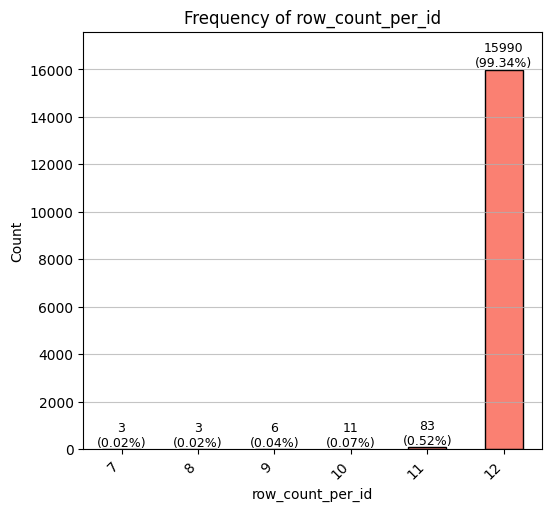

In [3]:
row_counts = price_df.groupby('id').size().reset_index(name='row_count_per_id')

plot_bar_charts(row_counts, ['row_count_per_id'])

Given this observation, we have decided to impute the missing values using the monthly medians:

In [4]:
price_numeric_cols = price_df.select_dtypes(include=['number']).columns

incomplete_clients = row_counts[row_counts['row_count_per_id'] < 12]["id"]

# Generate a complete date range for each client
date_range = pd.date_range(start="2015-01-01", periods=12, freq='MS')
dates_df = pd.DataFrame({price_date_col: date_range})

# Create complete combinations of client_id and months
all_combinations = (
    incomplete_clients.to_frame()
    .merge(dates_df, how="cross")
    .rename(columns={"id": "client_id"})
)

# Merge with existing data to find missing records
merged_data = (
    all_combinations.merge(
        price_df, left_on=["client_id", price_date_col], right_on=["id", price_date_col], how="left"
    )
    .drop(columns=["id"])
    .rename(columns={"client_id": "id"})
)

# Filter rows where any price variable is missing
missing_rows = merged_data[merged_data[price_numeric_cols].isnull().any(axis=1)]

# Step 5: Compute monthly medians
monthly_medians = price_df.groupby(price_date_col)[price_numeric_cols].median().reset_index()

# Step 6: Impute missing values
missing_rows = missing_rows.merge(monthly_medians, on=price_date_col, suffixes=("", "_Median"))

for col in price_numeric_cols:
    missing_rows[col] = missing_rows[col].fillna(missing_rows[f"{col}_Median"])
    missing_rows.drop(columns=[f"{col}_Median"], inplace=True)

# Concatenate imputed rows with original dataset
price_df = pd.concat([price_df, missing_rows], ignore_index=True)

After imputing the missing values, we perform a final check to ensure that there are no remaining missing values in the dataset.

In [5]:
# Ensure no missing values remain
print("Final Missing Values Check:")
print(price_df.isnull().sum())

Final Missing Values Check:
id                    0
price_date            0
price_off_peak_var    0
price_peak_var        0
price_mid_peak_var    0
price_off_peak_fix    0
price_peak_fix        0
price_mid_peak_fix    0
dtype: int64


### Computing summary statistics for price trends

Now that we have handled missing data, let's analyze the trends in the 6 price variables. We will plot both the average trend and individual trends for a randomly chosen sample of 100 customers:

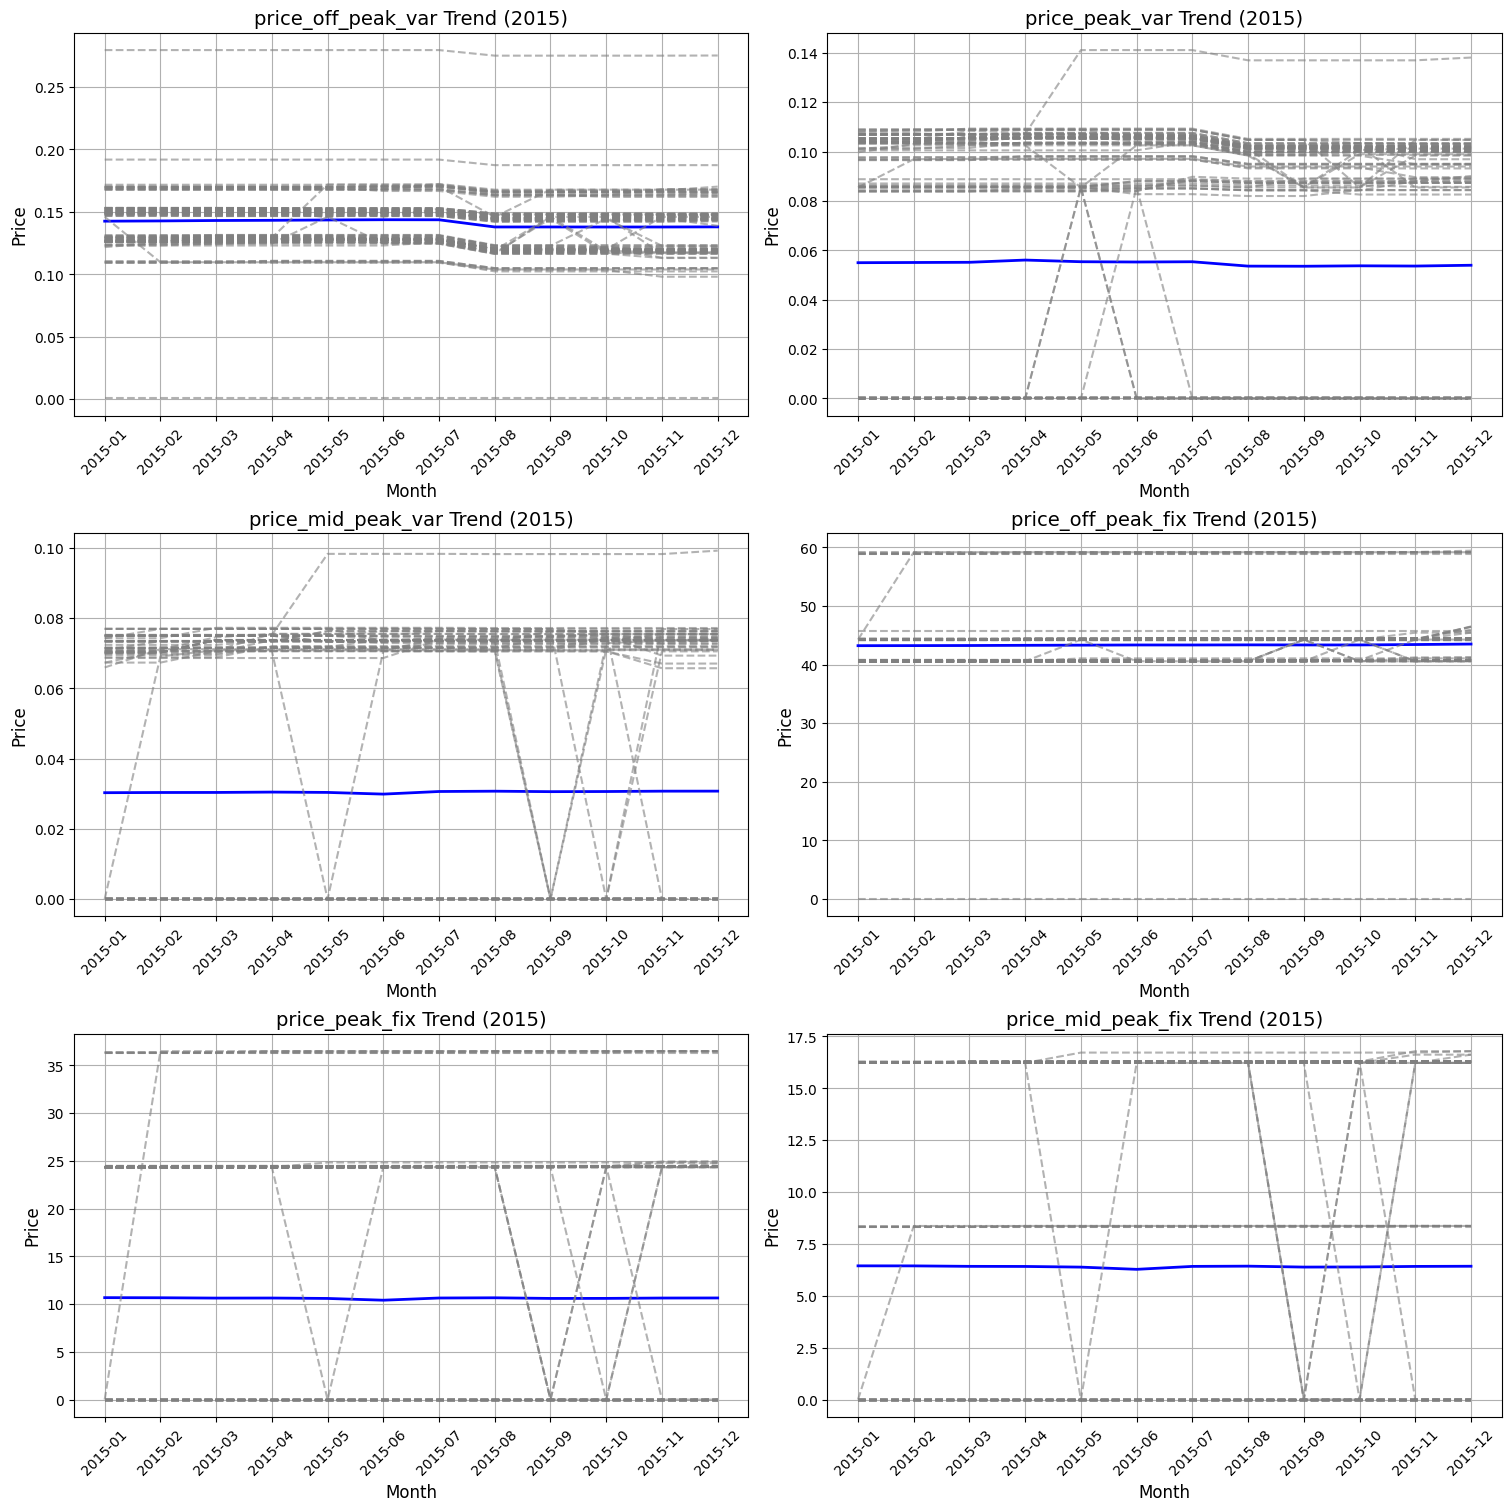

In [6]:
plot_price_trends(price_df, price_numeric_cols, price_date_col, 'id', n_sample=100)

As observed, while many of the individual trends remain relatively constant, some display noticeable spikes or troughs. To summarize these trends and facilitate their integration with the `client_df`, we will engineer several new price features. These features will capture key aspects of the trends, such as the mean, the standard deviation, the maximum difference between two consecutive months, and more.

In [7]:
price_df = price_df.sort_values(by=['id', price_date_col])

# Group by 'id'
grouped_df = price_df[['id']+price_numeric_cols.tolist()].groupby('id')

# Compute statistics
mean_df = grouped_df.mean()
median_df = grouped_df.median()
min_df = grouped_df.min()
max_df = grouped_df.max()
std_df = grouped_df.std()
max_diff_df = grouped_df.agg(lambda x: max(x.iloc[i+1] - x.iloc[i] for i in range(len(x)-1)))

# Rename columns for clarity
mean_df.columns = [f"{col}_mean" for col in price_numeric_cols]
median_df.columns = [f"{col}_median" for col in price_numeric_cols]
min_df.columns = [f"{col}_min" for col in price_numeric_cols]
max_df.columns = [f"{col}_max" for col in price_numeric_cols]
std_df.columns = [f"{col}_std" for col in price_numeric_cols]
max_diff_df.columns = [f"{col}_max_diff" for col in price_numeric_cols]

# Join all DataFrames on 'id'
price_summary_df = pd.concat([mean_df, min_df, max_df, std_df, max_diff_df], axis=1)

# Reset index for a cleaner DataFrame if needed
price_summary_df.reset_index(inplace=True)

price_summary_df

,id,price_off_peak_var_mean,price_peak_var_mean,price_mid_peak_var_mean,price_off_peak_fix_mean,price_peak_fix_mean,price_mid_peak_fix_mean,price_off_peak_var_min,price_peak_var_min,price_mid_peak_var_min,...,price_mid_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_mid_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff,price_peak_fix_max_diff,price_mid_peak_fix_max_diff
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,0.119906,0.101673,0.070232,...,0.001368,6.341481e-02,0.038049,0.025366,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,0.143943,0.000000,0.000000,...,0.000000,8.753223e-02,0.000000,0.000000,0.000358,0.000000,0.000000,0.177779,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,0.150837,0.000000,0.000000,...,0.000000,7.723930e-01,0.000000,0.000000,0.052694,0.000000,0.000000,1.500000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,0.113068,0.095385,0.068646,...,0.000403,8.507958e-02,0.051048,0.034032,0.000000,0.000000,0.000817,0.162912,0.097752,0.065172
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,0.145440,0.000000,0.000000,...,0.000000,5.908392e-07,0.000000,0.000000,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972,0.112488,0.094804,0.068829,...,0.012503,1.749923e-01,0.209025,0.226040,0.002317,0.002317,0.002317,0.000000,0.000005,0.000002
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000,0.144363,0.000000,0.000000,...,0.000000,8.040373e-02,0.000000,0.000000,0.000684,0.000000,0.000000,0.177780,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569,0.151399,0.126871,0.091394,...,0.004310,8.491973e-02,0.051364,0.034586,0.004084,0.002317,0.002317,0.164916,0.099749,0.067166
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678,0.118175,0.100491,0.073433,...,0.000471,7.368063e-02,0.044209,0.029474,0.000000,0.000000,0.001083,0.162912,0.097752,0.065172


### Merging the 2 tables

Now that we have summarized the price trends and engineered the relevant features, we can merge the `price_summary_df` with the `client_df` dataset using an inner join:

In [8]:
# Perform an inner join based on 'id'
merged_df = pd.merge(client_df, price_summary_df, on='id', how='inner')

merged_df

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_mid_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_mid_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff,price_peak_fix_max_diff,price_mid_peak_fix_max_diff
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.020983,1.050136e+00,7.039226,4.692817,0.028554,0.000568,0.002337,3.538045,0.097752,0.065172
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,8.040385e-02,0.000000,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,8.753223e-02,0.000000,0.000000,0.000000,0.001281,0.000000,0.177779,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,Channel 2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,8.040349e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.177779,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.001588,7.368135e-02,0.044209,0.029473,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14548,18463073fb097fc0ac5d3e040f356987,Channel 1,32270,47940,0,2012-05-24,2016-05-08,2015-05-08,2014-05-26,4648.01,...,0.000000,9.154352e-02,0.000000,0.000000,0.000569,0.000000,0.000000,0.177780,0.000000,0.000000
14549,d0a6f71671571ed83b2645d23af6de00,Channel 1,7223,0,181,2012-08-27,2016-08-27,2012-08-27,2015-08-28,631.69,...,0.000128,1.165389e-01,0.071868,0.016479,0.000000,0.000000,0.000260,0.236688,0.145968,0.033468
14550,10e6828ddd62cbcf687cb74928c4c2d2,Channel 1,1844,0,179,2012-02-08,2016-02-07,2012-02-08,2015-02-09,190.39,...,0.001368,6.341481e-02,0.038049,0.025366,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
14551,1cf20fd6206d7678d5bcafd28c53b4db,Channel 1,131,0,0,2012-08-30,2016-08-30,2012-08-30,2015-08-31,19.34,...,0.000000,8.040379e-02,0.000000,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000


### Analysis of date variables

Let's examine the minimum and maximum values for the date variables in `merged_df`:

In [9]:
# 2. Create a table with min and max values for each date variable
datetime_cols = merged_df.select_dtypes(include=['datetime']).columns
date_summary = merged_df[datetime_cols].agg(['min', 'max']).transpose()
date_summary.columns = ['Minimum Date', 'Maximum Date']

# Display the results
print("Date Summary Table:")
date_summary

Date Summary Table:


,Minimum Date,Maximum Date
date_activ,2003-05-09,2014-09-01
date_end,2016-01-28,2017-06-13
date_modif_prod,2003-05-09,2016-01-29
date_renewal,2013-06-26,2016-01-28


Before removing the date columns, we'll create the following features from the date variables:

- `product_modified`: A binary variable indicating whether the product was modified after activation.
- `contract_age_at_last_modif`: The number of days between contract activation (`date_activ`) and the last product modification date (`date_modif_prod`).
- `days_to_end`: The number of days between the end of the historical period (December 31, 2015) and the contract end date.

In [10]:
# Compute 'product_modified'
merged_df.loc[:, 'product_modified'] = (merged_df['date_modif_prod'] > merged_df['date_activ']).astype(int).astype('object')
merged_df.loc[:, 'product_modified'] = merged_df['product_modified'].map({0: 'No', 1: 'Yes'})

# Compute 'contract_age_at_last_modif'
merged_df.loc[:, 'contract_age_at_last_modif'] = (merged_df['date_modif_prod'] - merged_df['date_activ']).dt.days

# Compute 'days_to_end'
historical_end_date = pd.Timestamp('2015-12-31')
merged_df.loc[:, 'days_to_end'] = (merged_df['date_end'] - historical_end_date).dt.days

merged_df[['date_activ', 'date_modif_prod', 'product_modified', 'contract_age_at_last_modif', 'date_end', 'days_to_end']].head(10)

,date_activ,date_modif_prod,product_modified,contract_age_at_last_modif,date_end,days_to_end
0,2013-06-15,2015-11-01,Yes,869,2016-06-15,167
1,2009-08-21,2009-08-21,No,0,2016-08-30,243
2,2010-04-16,2010-04-16,No,0,2016-04-16,107
3,2010-03-30,2010-03-30,No,0,2016-03-30,90
4,2010-01-13,2010-01-13,No,0,2016-03-07,67
5,2011-12-09,2015-11-01,Yes,1423,2016-12-09,344
6,2011-12-02,2011-12-02,No,0,2016-12-02,337
7,2010-04-21,2010-04-21,No,0,2016-04-21,112
8,2011-09-23,2011-09-23,No,0,2016-09-23,267
9,2010-05-04,2015-04-29,Yes,1821,2016-05-04,125


Finally, let's drop the date columns since we no longer need them:

In [11]:
merged_df.drop(datetime_cols, axis=1, inplace=True)

### Saving the first version of the dataset

Before we proceed with additional data transformations and feature engineering, we will save the current version of the dataset. This will allow us to evaluate whether the following steps improve model performance:

In [12]:
merged_df.to_csv(f"{repo_path}/data/merged_data_no_tfm.csv", index=False)

### Analysis of numeric variables

Let's begin by visualizing the distributions of the numeric variables in the dataset using the `plot_numeric_distributions` custom function.

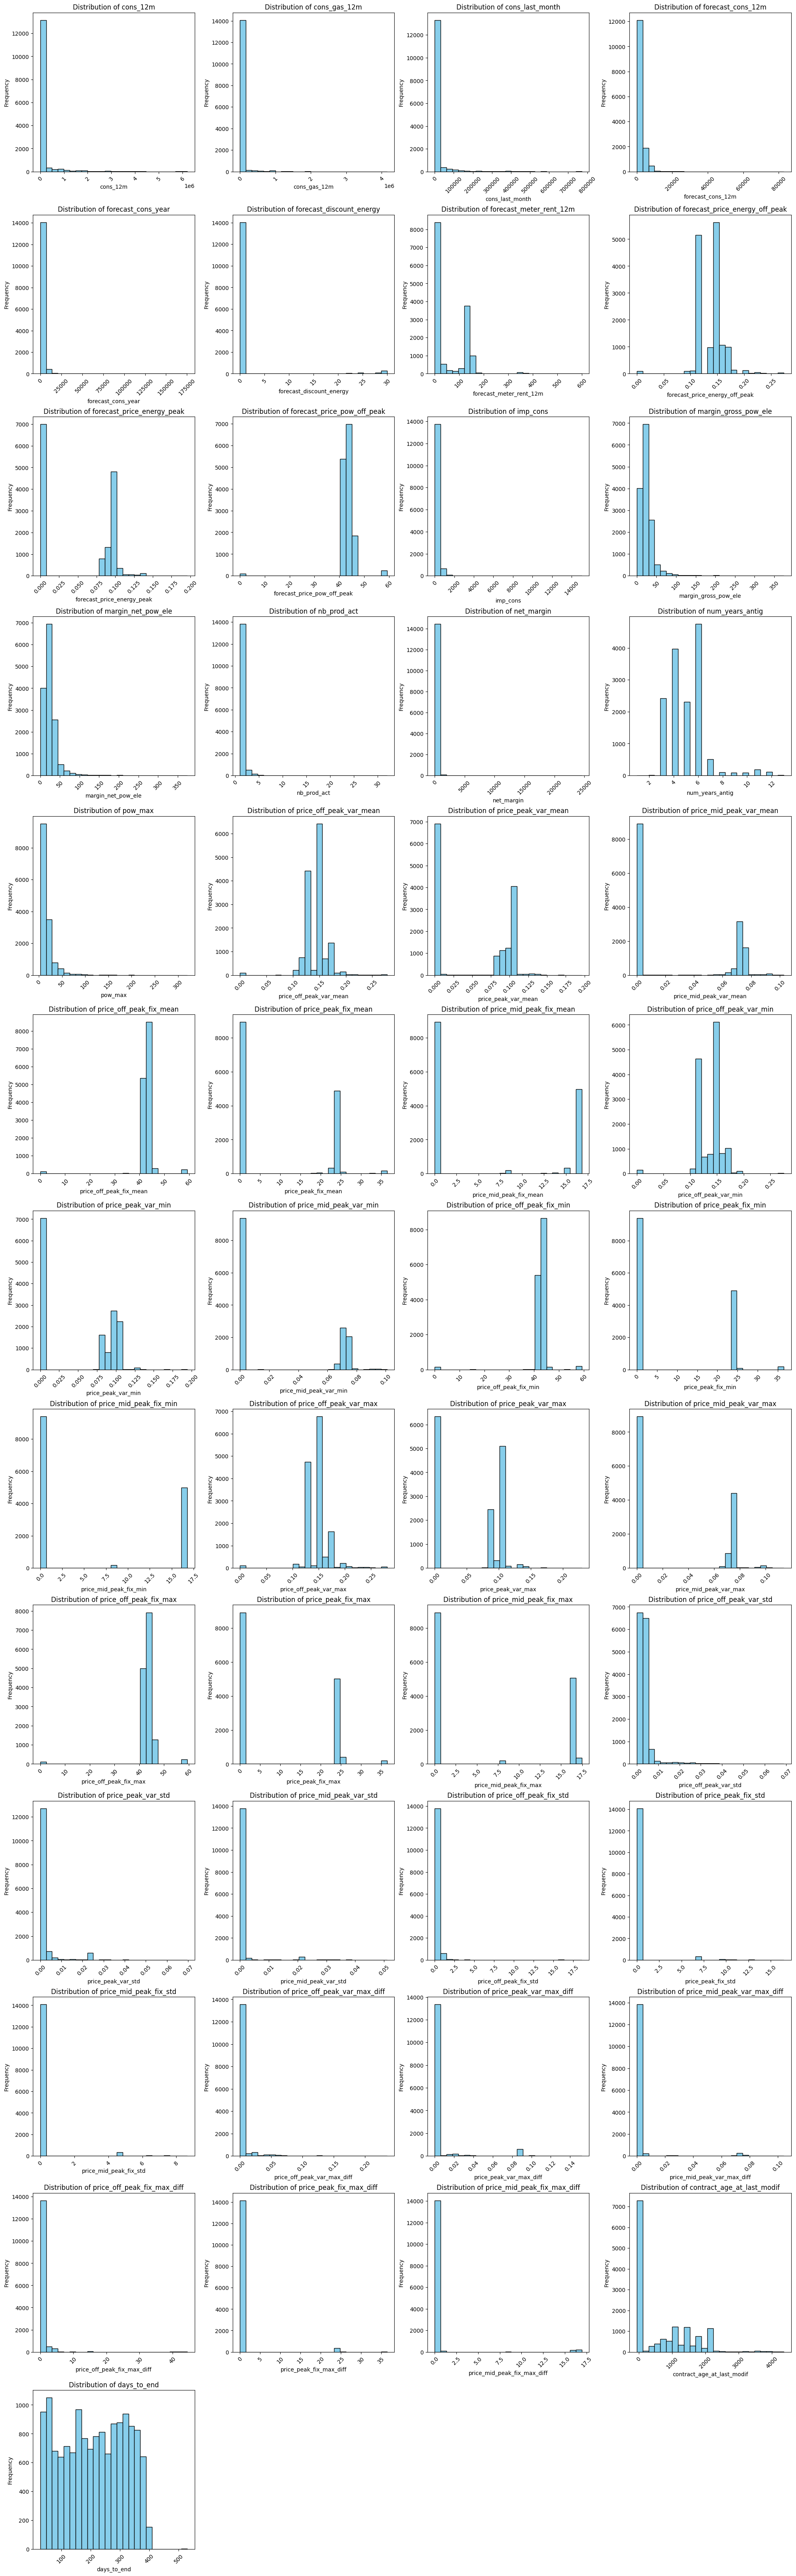

In [13]:
numeric_cols = merged_df.select_dtypes(include='number').columns

plot_numeric_distributions(merged_df, numeric_cols, n_cols=4)

As we can observe, many of the predictors exhibit extreme skewness. This is problematic because the number of observations available to predict the target can vary greatly across the input value range. To better understand this, let's compute the skewness, the number of zeros, and the cardinality (number of unique values) for each of the numeric columns.

In [14]:
num_stats_df = compute_and_sort_statistics(merged_df, numeric_cols, by='cardinality', ascending=True)
num_stats_df

,skewness,zero_counts,cardinality
nb_prod_act,8.645545,0,10
forecast_discount_energy,5.150422,14042,12
num_years_antig,1.447841,0,13
price_mid_peak_fix_min,0.636789,9399,13
price_peak_fix_min,0.658429,9399,13
price_mid_peak_fix_max,0.493503,8924,15
price_peak_fix_max,0.514941,8924,16
price_off_peak_fix_min,-5.750355,139,30
price_peak_fix_max_diff,5.870085,10360,37
price_mid_peak_fix_max_diff,5.811189,10324,39


Let's focus on the first three variables in the table above (`forecast_discount_energy`, `nb_prod_act`, and `num_years_antig`), sorted by cardinality, and plot their value frequencies.

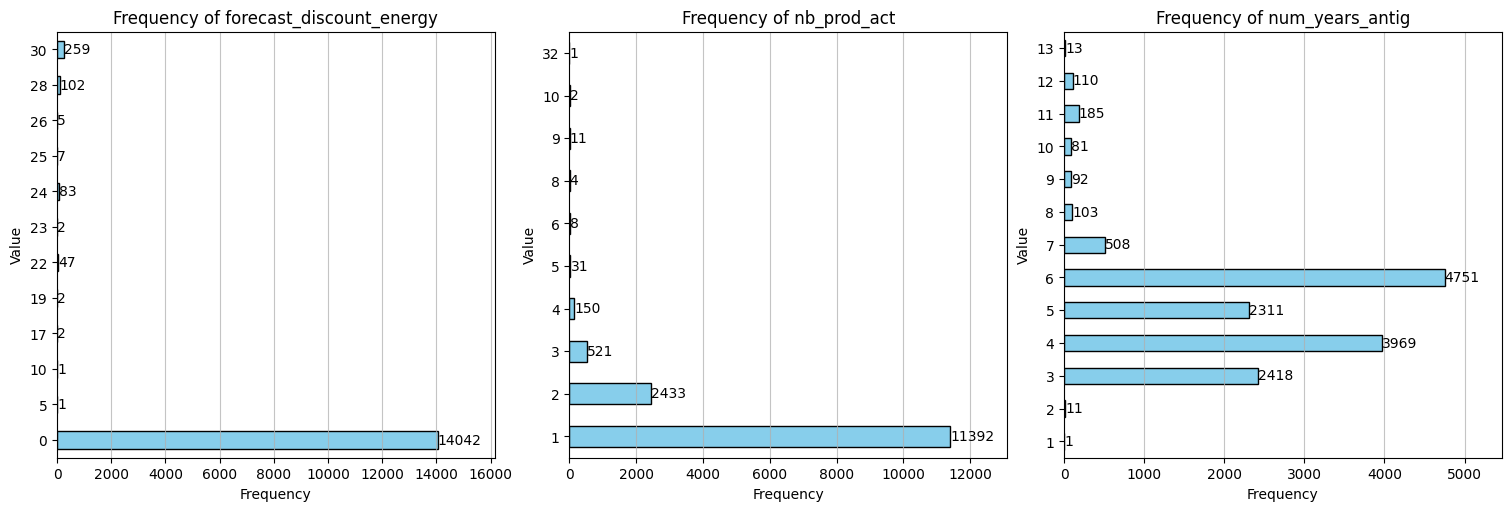

In [15]:
low_cardinality_cols = ['forecast_discount_energy', 'nb_prod_act', 'num_years_antig']

plot_bar_charts(merged_df, low_cardinality_cols, orientation='horizontal', ncols=3)

For these three variables, we decided to create categorical variables to group the rare values. This can help in reducing overfitting and generalizing better on unseen data. The transformations applied are as follows:

- `nb_prod_act`: Three categories: '1', '2', and '3 or more'.
- `num_years_antig`: Five categories: '3 or less', '4', '5', '6', and '7 or more'.
- `forecast_discount_energy`: A binary flag variable called `is_zero_forecast_discount_energy` to indicate whether the value is 0 or non-zero, with values `'No'` and `'Yes'`.

In [16]:
# Transformation for `nb_prod_act`
merged_df['nb_prod_act_cat'] = np.where(merged_df['nb_prod_act'] >= 3, '3 or more',
                                        merged_df['nb_prod_act'].astype(str))

# Transformation for `num_years_antig`
merged_df['num_years_antig_cat'] = np.where(merged_df['num_years_antig'] <= 3, '3 or less',
                                        np.where(merged_df['num_years_antig'] == 4, '4',
                                                np.where(merged_df['num_years_antig'] == 5, '5',
                                                        np.where(merged_df['num_years_antig'] == 6, '6', '7 or more'))))

# Transformation for `forecast_discount_energy`
merged_df['is_zero_forecast_discount_energy'] = np.where(merged_df['forecast_discount_energy'] > 0, 'No', 'Yes')

Let's now visualize the newly created categorical variables by plotting bar charts, and remove the original numeric columns from the dataset.

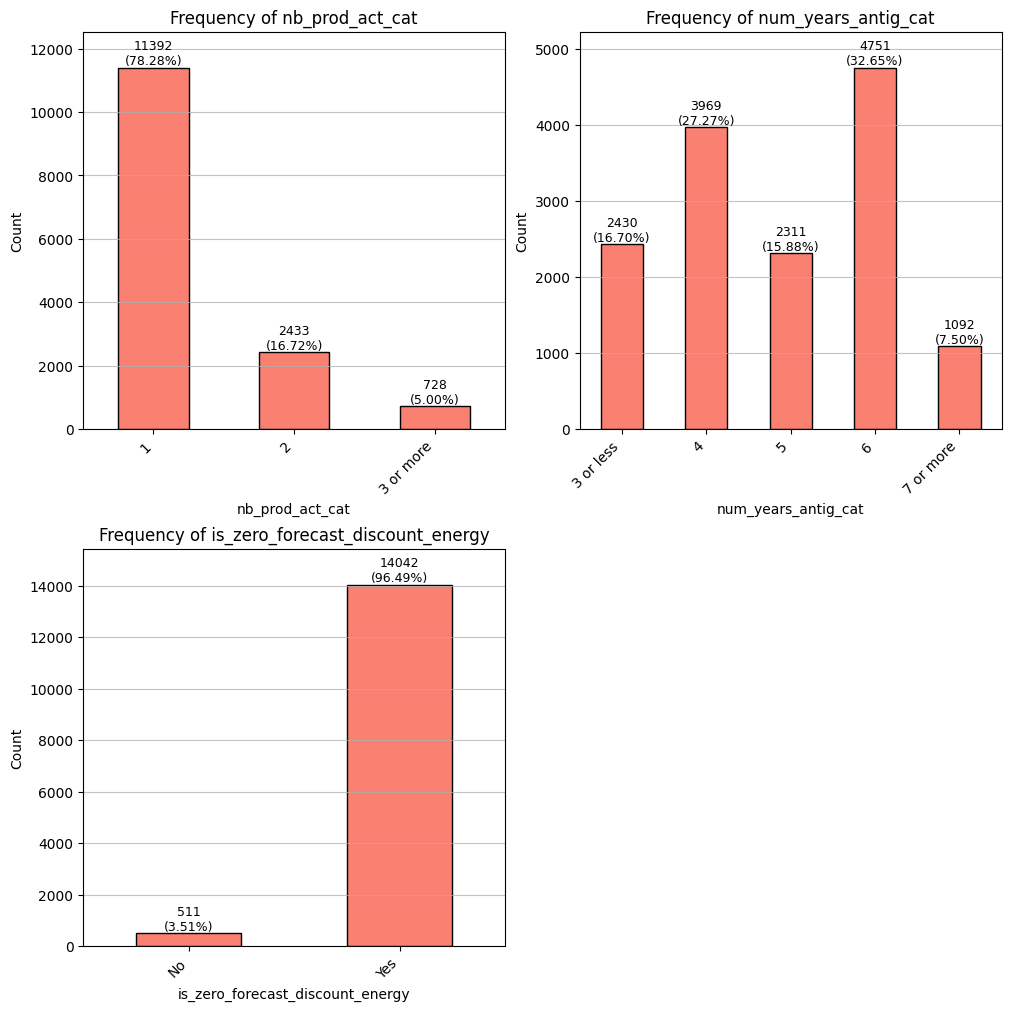

In [17]:
# Remove the original variables
merged_df.drop(low_cardinality_cols, axis=1, inplace=True)

categorized_cols = ['nb_prod_act_cat', 'num_years_antig_cat', 'is_zero_forecast_discount_energy']

plot_bar_charts(merged_df, categorized_cols, orientation='vertical')

Now, let's proceed with the analysis of the remaining numeric variables. We will sort them by the number of zeros in their values.

In [18]:
numeric_cols = [col for col in numeric_cols if col not in low_cardinality_cols]

num_stats_df = num_stats_df.loc[numeric_cols].sort_values(by='zero_counts', ascending=False)
num_stats_df

,skewness,zero_counts,cardinality
cons_gas_12m,9.647826,11994,2063
price_peak_fix_max_diff,5.870085,10360,37
price_mid_peak_fix_max_diff,5.811189,10324,39
price_mid_peak_fix_std,5.782460,9666,351
price_peak_fix_std,5.754439,9666,364
price_mid_peak_var_max_diff,5.567288,9611,686
price_peak_fix_min,0.658429,9399,13
price_mid_peak_fix_min,0.636789,9399,13
price_mid_peak_var_min,0.618610,9385,332
price_mid_peak_var_std,5.423679,8982,1886


Several columns contain a large number of zeros. Let's examine the distributions of these variables when removing the rows with zeros (for those variables with more than 30% zeros).

Skewness for column cons_gas_12m (excluding zeros): 3.916
---------------------------------
Skewness for column cons_last_month (excluding zeros): 5.126
---------------------------------
Skewness for column forecast_cons_year (excluding zeros): 14.927
---------------------------------
Skewness for column forecast_price_energy_peak (excluding zeros): 2.194
---------------------------------
Skewness for column imp_cons (excluding zeros): 11.925
---------------------------------
Skewness for column price_peak_var_mean (excluding zeros): -2.446
---------------------------------
Skewness for column price_mid_peak_var_mean (excluding zeros): -4.025
---------------------------------
Skewness for column price_peak_fix_mean (excluding zeros): -0.139
---------------------------------
Skewness for column price_mid_peak_fix_mean (excluding zeros): -4.345
---------------------------------
Skewness for column price_peak_var_min (excluding zeros): 0.727
---------------------------------
Skewness for 

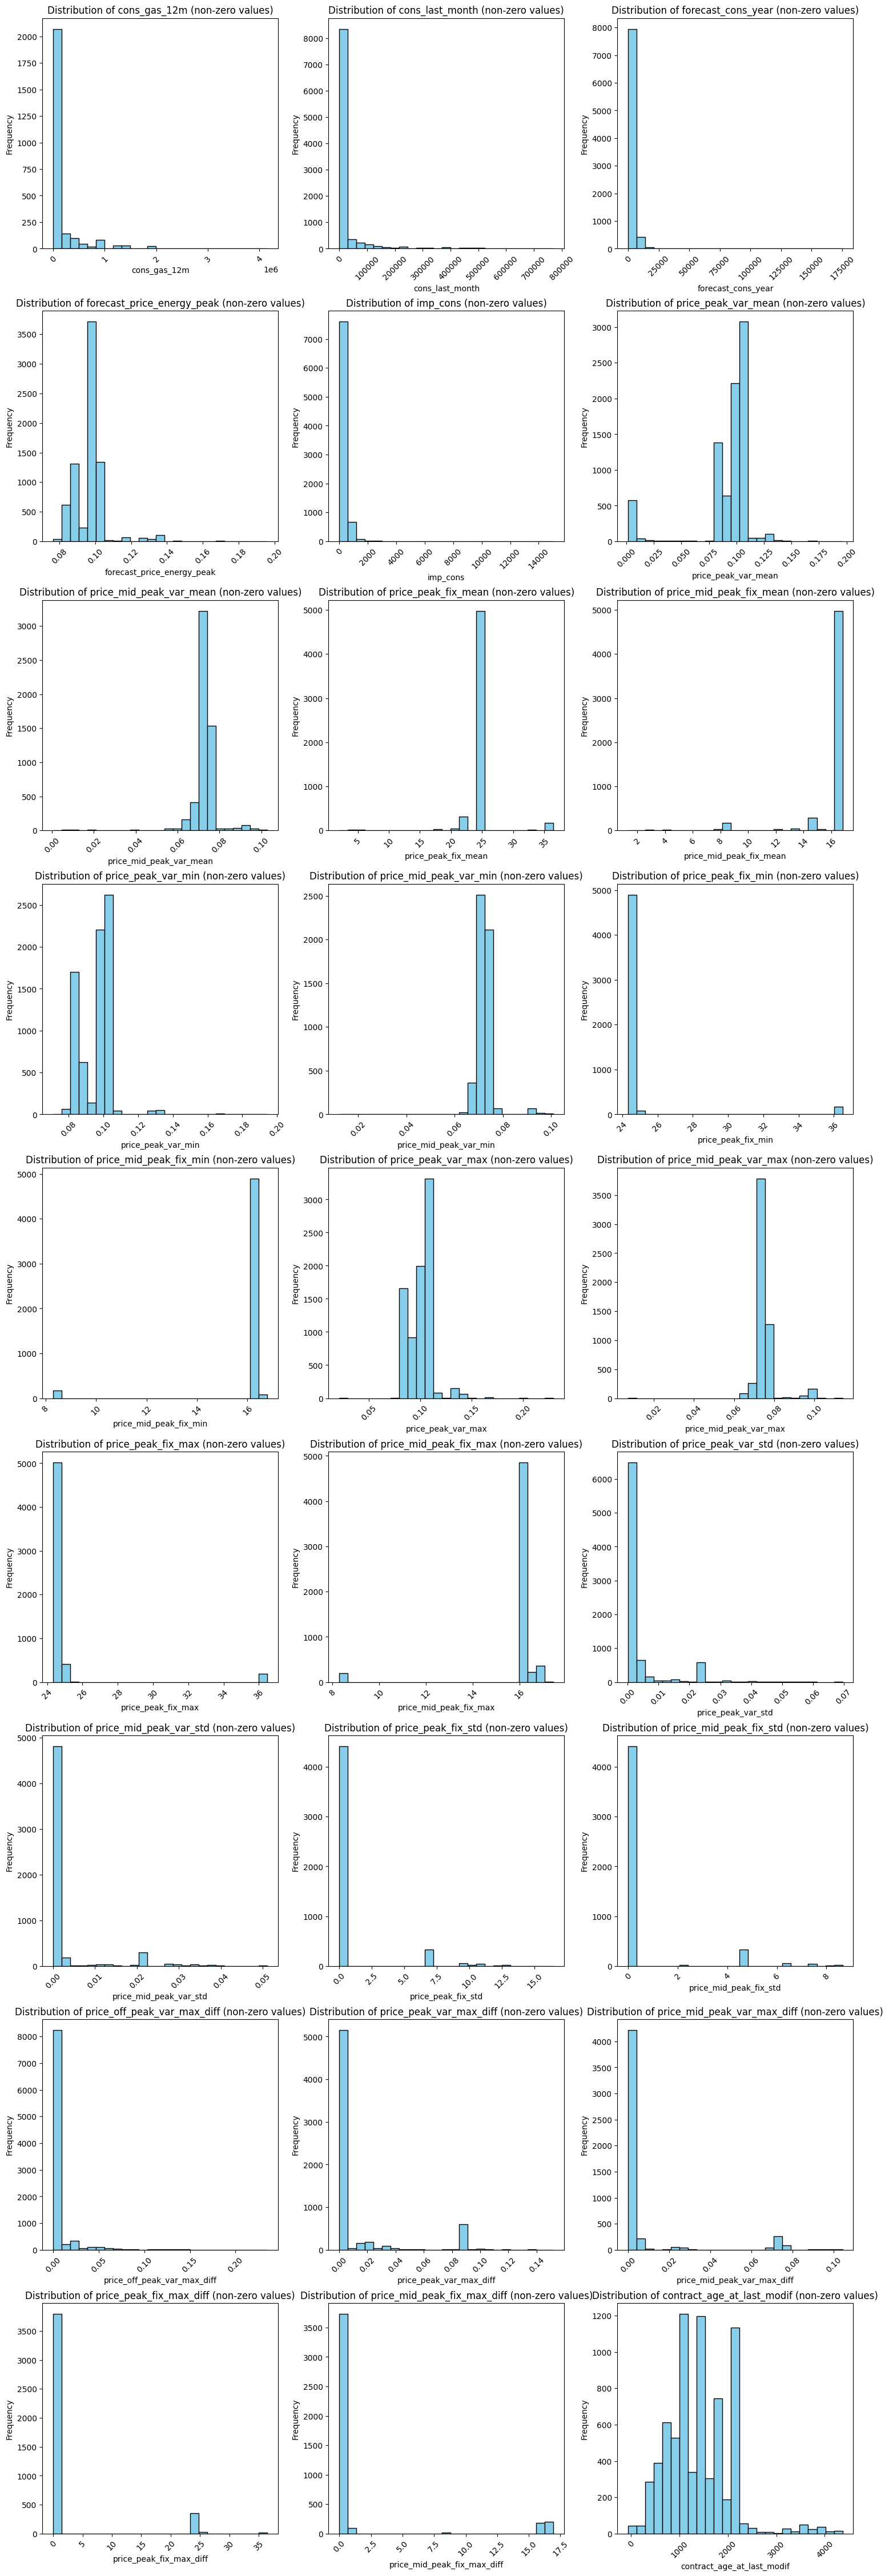

In [19]:
plot_histograms_for_sparse_cols(merged_df, numeric_cols, zero_threshold=0.3)

Some of these distributions still exhibit high skewness even after removing the zeros. To address this, we can create additional features:

- A binary flag indicating whether the variable value is in the spike (0) or is from the distribution (non-zero value).
- A transformed variable where the 0 values are set to missing, and a log or square transformation (depending on the sign of the skewness) is applied to the non-zero values. Variables with skewness less than 3 in absolute value will not undergo transformation, and missing values (i.e., the removed 0 values) will be imputed during model building.

This approach follows the procedure outlined in this [SAS paper](https://support.sas.com/resources/papers/proceedings/proceedings/forum2007/073-2007.pdf), on pages 3-4.

In [20]:
many_zeros_cols = [col for col in num_stats_df.index if num_stats_df.loc[col,'zero_counts']>0.3*len(merged_df)]

merged_df, distr_transformed_cols = engineer_saz_features(merged_df, many_zeros_cols, skewness_threshold=3.0)

Finally, let's remove the original columns involved in these transformations.

In [21]:
merged_df.drop(many_zeros_cols, axis=1, inplace=True)

Let's focus on the remaining numeric variables:

In [22]:
numeric_cols = [col for col in numeric_cols if col not in many_zeros_cols]

num_stats_df = num_stats_df.loc[numeric_cols].sort_values(by='skewness', ascending=False)
num_stats_df

,skewness,zero_counts,cardinality
net_margin,36.532338,184,11934
price_off_peak_fix_max_diff,15.357051,3160,112
price_off_peak_fix_std,14.932745,1386,880
forecast_cons_12m,7.150192,305,13945
price_off_peak_var_std,6.419539,100,4656
cons_12m,5.985830,117,11033
pow_max,5.782138,0,697
margin_net_pow_ele,4.468047,157,2385
margin_gross_pow_ele,4.467349,157,2385
forecast_meter_rent_12m,1.506613,723,3517


We decided to apply a **log transformation** to all remaining variables with a skewness greater than 3, and a **square transformation** to those with a skewness lower than -3. This was done to achieve a more consistent distribution across their range of values, addressing the skewness issue we discussed earlier.

In [23]:
skewness = num_stats_df['skewness']
cols_to_transform = [col for col in num_stats_df.index if abs(skewness[col])>3]
transformed_cols = []

for col in cols_to_transform:
    if skewness[col]<0:
        col_name = f"{col}_square"
        merged_df[col_name] = merged_df[col].apply(lambda x: x**2)
    elif skewness[col]>0:
        col_name = f"{col}_log"
        merged_df[col_name] = merged_df[col].apply(lambda x: np.log1p(x))

    transformed_cols.append(col_name)

# Print the transformed columns
print(f"Transformed columns: {cols_to_transform}")

Transformed columns: ['net_margin', 'price_off_peak_fix_max_diff', 'price_off_peak_fix_std', 'forecast_cons_12m', 'price_off_peak_var_std', 'cons_12m', 'pow_max', 'margin_net_pow_ele', 'margin_gross_pow_ele', 'forecast_price_pow_off_peak', 'price_off_peak_fix_max', 'price_off_peak_fix_mean', 'price_off_peak_fix_min']


Now, let's remove the non-transformed numeric variables:

In [24]:
merged_df.drop(cols_to_transform, axis=1, inplace=True)

### Categorical variables

Let’s move on to the categorical variables:

In [25]:
categorical_cols = [col for col in merged_df.select_dtypes(exclude='number').columns if col!='id']
categorical_cols

['channel_sales',
 'has_gas',
 'origin_up',
 'churn',
 'product_modified',
 'nb_prod_act_cat',
 'num_years_antig_cat',
 'is_zero_forecast_discount_energy',
 'is_zero_cons_gas_12m',
 'is_zero_price_peak_fix_max_diff',
 'is_zero_price_mid_peak_fix_max_diff',
 'is_zero_price_mid_peak_fix_std',
 'is_zero_price_peak_fix_std',
 'is_zero_price_mid_peak_var_max_diff',
 'is_zero_price_peak_fix_min',
 'is_zero_price_mid_peak_fix_min',
 'is_zero_price_mid_peak_var_min',
 'is_zero_price_mid_peak_var_std',
 'is_zero_price_mid_peak_fix_mean',
 'is_zero_price_peak_fix_max',
 'is_zero_price_mid_peak_fix_max',
 'is_zero_price_peak_fix_mean',
 'is_zero_price_mid_peak_var_mean',
 'is_zero_price_mid_peak_var_max',
 'is_zero_price_peak_var_max_diff',
 'is_zero_contract_age_at_last_modif',
 'is_zero_price_peak_var_min',
 'is_zero_forecast_price_energy_peak',
 'is_zero_price_peak_var_std',
 'is_zero_price_peak_var_max',
 'is_zero_price_peak_var_mean',
 'is_zero_imp_cons',
 'is_zero_forecast_cons_year',
 'is_

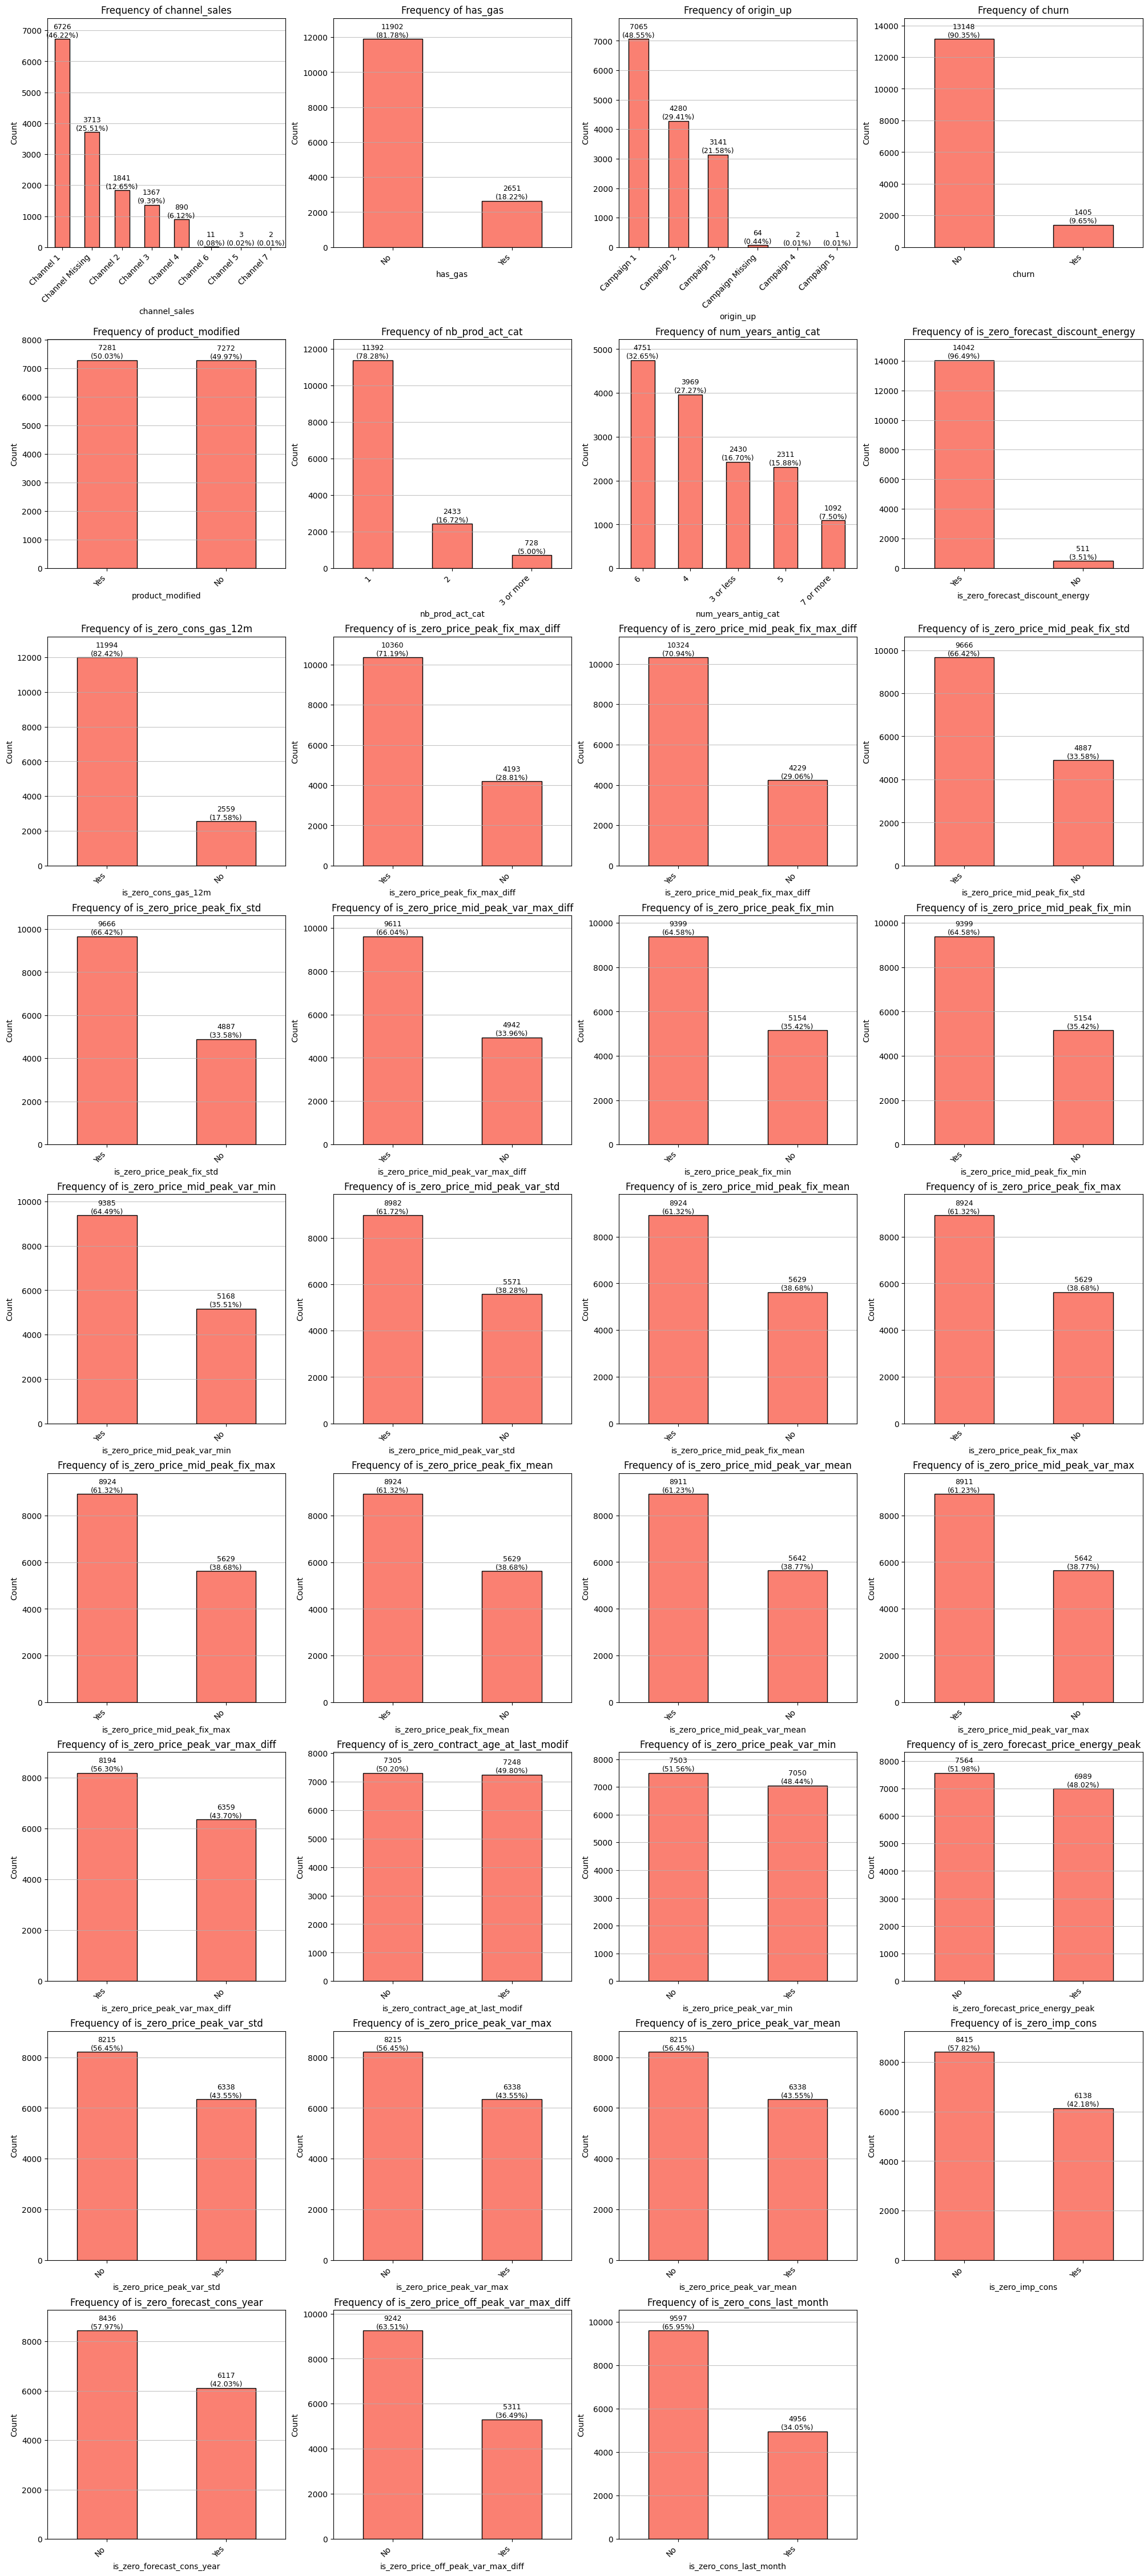

In [26]:
plot_bar_charts(merged_df, categorical_cols, sort_index=False, ncols=4)

As you can see, some categories are underrepresented, particularly:

- `'Channel 5'`, `'Channel 6'`, and `'Channel 7'` in the `channel_sales` variable.
- `'Campaign 4'`, `'Campaign 5'`, and `'Campaign Missing'` in the `origin_up` variable.

Since these categories account for a very small portion of the data, they are likely to introduce noise without offering enough examples for learning meaningful patterns. Therefore, we decided to remove rows corresponding to categories that account for less than 1% of the total observations.

In [27]:
merged_df = remove_underrepresented_categories(merged_df, categorical_cols)


Removed categories from 'channel_sales':
  - Channel 6
  - Channel 5
  - Channel 7

Removed categories from 'origin_up':
  - Campaign Missing
  - Campaign 4
  - Campaign 5


### Removing highly correlated variables

Let’s now examine the **correlation matrix** for the numeric variables, focusing only on correlations greater than 0.9:

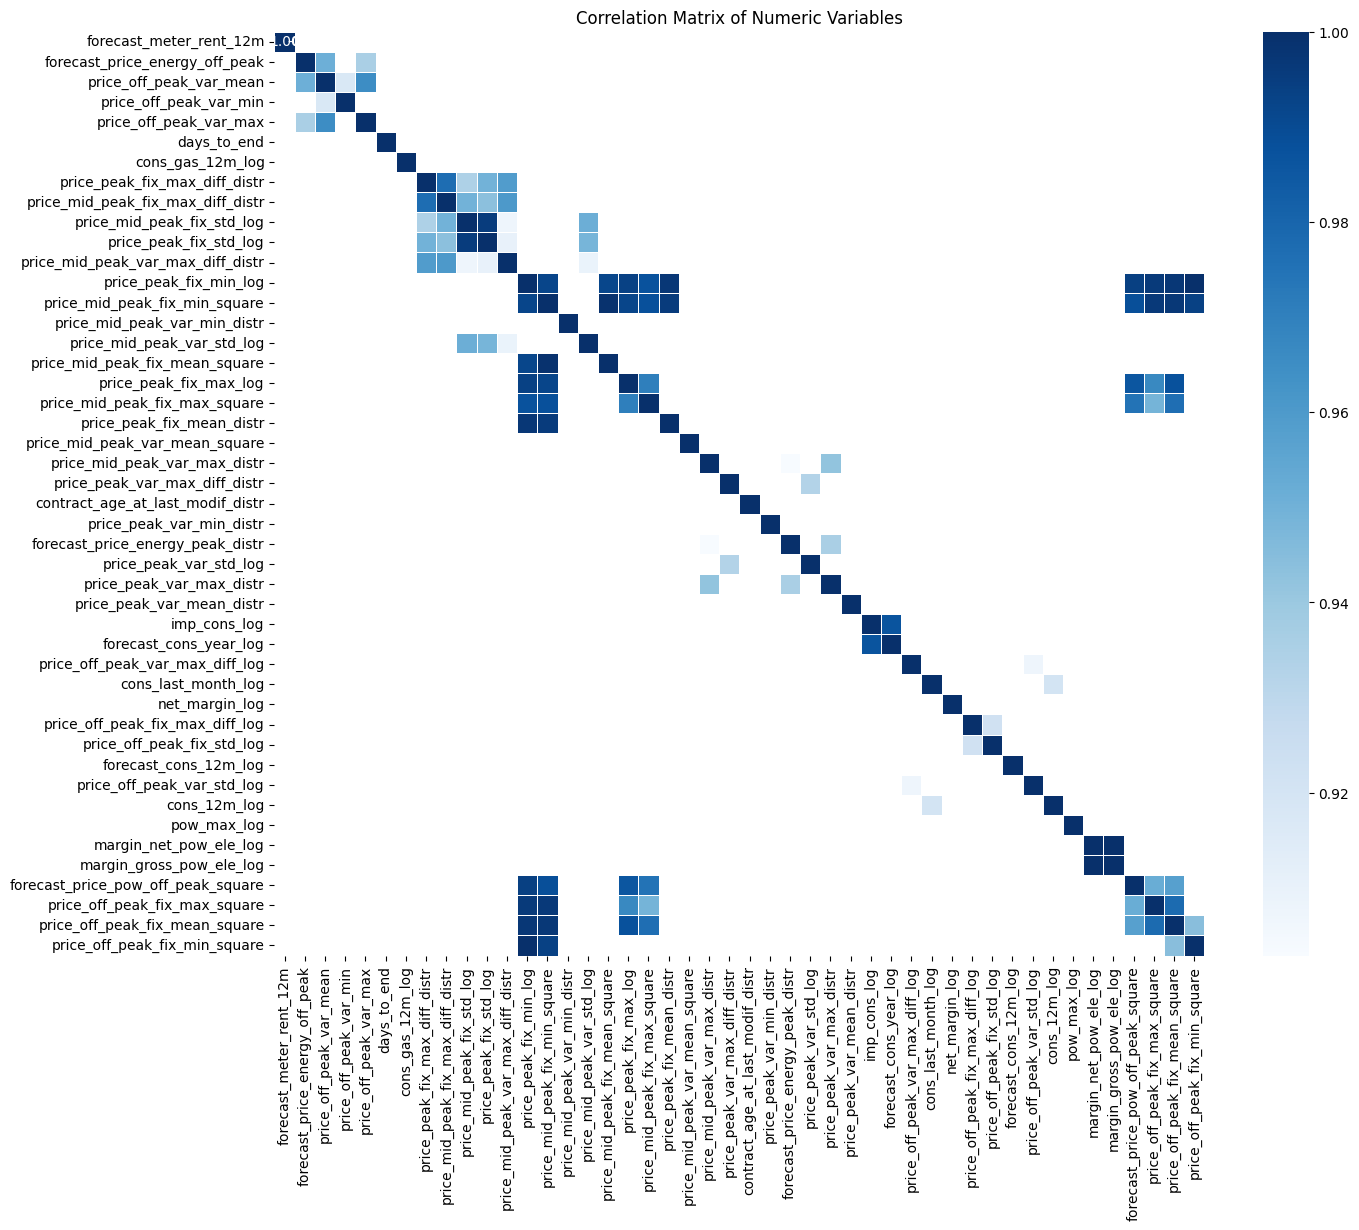

,variable_1,variable_2,correlation
1020,margin_net_pow_ele_log,margin_gross_pow_ele_log,0.999892
506,price_peak_fix_min_log,price_off_peak_fix_min_square,0.999798
509,price_mid_peak_fix_min_square,price_mid_peak_fix_mean_square,0.999109
505,price_peak_fix_min_log,price_off_peak_fix_mean_square,0.997273
480,price_peak_fix_min_log,price_peak_fix_mean_distr,0.997244
504,price_peak_fix_min_log,price_off_peak_fix_max_square,0.995960
369,price_mid_peak_fix_std_log,price_peak_fix_std_log,0.995248
503,price_peak_fix_min_log,forecast_price_pow_off_peak_square,0.993943
478,price_peak_fix_min_log,price_peak_fix_max_log,0.993608
511,price_mid_peak_fix_min_square,price_mid_peak_fix_max_square,0.988184


In [28]:
high_corr_pairs = plot_correlation_matrix(merged_df, merged_df.select_dtypes(include='number').columns)
high_corr_pairs.sort_values(by="correlation", ascending=False)

As seen from the matrix, several pairs of variables exhibit a high correlation (greater than 0.9). These variables convey nearly the same information, so to reduce redundancy, we applied the custom `process_graph` function. This function iteratively removes variables based on their connectivity in the correlation graph. Within each connected component of highly correlated variables, the function removes nodes (variables) with the highest number of connections, prioritizing those with the strongest correlations. This continues until no strongly correlated pairs remain.

In [29]:
variables_to_remove = process_graph(high_corr_pairs)

Initial graph:
Graph with 35 nodes and 54 edges
The graph is made of the following components:
1) {'forecast_price_energy_off_peak', 'price_off_peak_var_max', 'price_off_peak_var_min', 'price_off_peak_var_mean'}
2) {'price_peak_fix_std_log', 'price_mid_peak_var_max_diff_distr', 'price_peak_fix_max_diff_distr', 'price_mid_peak_fix_max_diff_distr', 'price_mid_peak_var_std_log', 'price_mid_peak_fix_std_log'}
3) {'price_mid_peak_fix_mean_square', 'forecast_price_pow_off_peak_square', 'price_off_peak_fix_max_square', 'price_peak_fix_max_log', 'price_off_peak_fix_min_square', 'price_off_peak_fix_mean_square', 'price_peak_fix_min_log', 'price_mid_peak_fix_max_square', 'price_mid_peak_fix_min_square', 'price_peak_fix_mean_distr'}
4) {'price_mid_peak_var_max_distr', 'forecast_price_energy_peak_distr', 'price_peak_var_max_distr'}
5) {'price_peak_var_std_log', 'price_peak_var_max_diff_distr'}
6) {'forecast_cons_year_log', 'imp_cons_log'}
7) {'price_off_peak_var_std_log', 'price_off_peak_var_max_d

Now, let's remove the identified variables from the dataset and save the transformed data:

In [30]:
print("Variables to remove:", variables_to_remove)
print("Pre-removal shape:", merged_df.shape)
merged_df.drop(variables_to_remove, axis=1, inplace=True)
print("Post-removal shape:", merged_df.shape)

merged_df.to_csv(f"{repo_path}/data/merged_data_tfm.csv", index=False)

Variables to remove: ['price_off_peak_var_mean', 'price_mid_peak_fix_std_log', 'price_peak_fix_min_log', 'price_peak_var_max_distr', 'price_peak_var_max_diff_distr', 'forecast_cons_year_log', 'price_off_peak_var_max_diff_log', 'cons_12m_log', 'price_off_peak_fix_max_diff_log', 'margin_gross_pow_ele_log', 'forecast_price_energy_off_peak', 'price_mid_peak_var_max_diff_distr', 'price_mid_peak_fix_min_square', 'forecast_price_energy_peak_distr', 'price_peak_fix_std_log', 'price_off_peak_fix_mean_square', 'price_mid_peak_fix_max_diff_distr', 'price_peak_fix_max_log', 'price_off_peak_fix_max_square', 'forecast_price_pow_off_peak_square']
Pre-removal shape: (14470, 82)
Post-removal shape: (14470, 62)


Finally, let's apply the same process to the table previously saved in `merged_data_no_tfm.csv` and update its content accordingly:

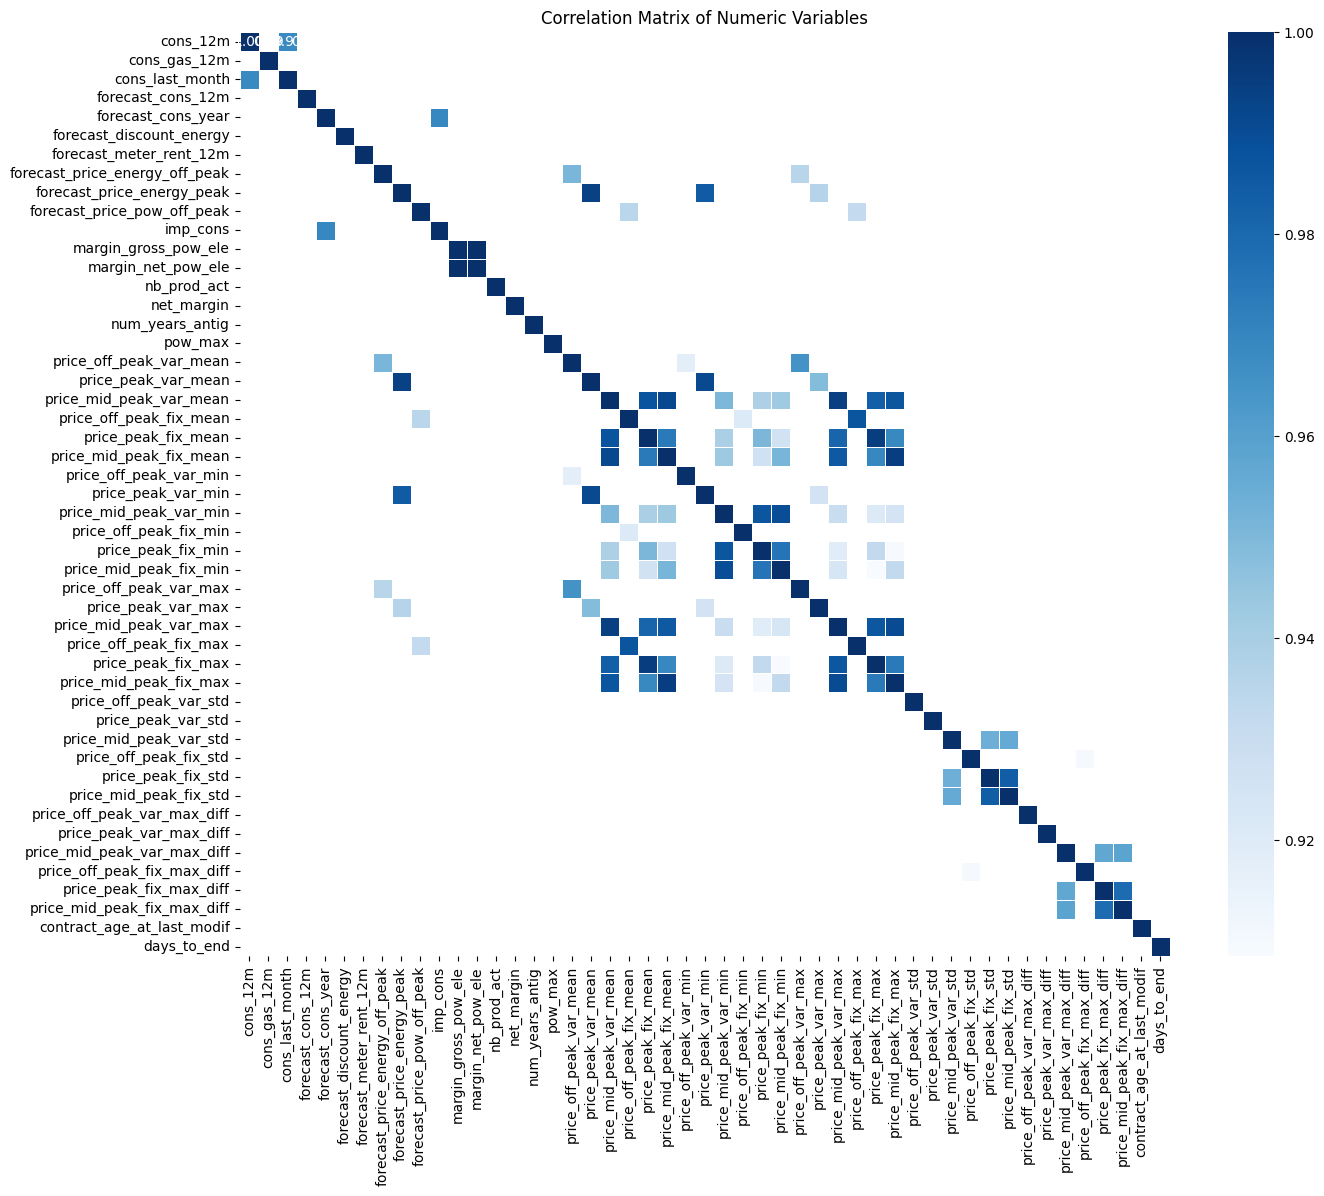

,variable_1,variable_2,correlation
473,margin_gross_pow_ele,margin_net_pow_ele,0.999913
809,price_peak_fix_mean,price_peak_fix_max,0.995184
836,price_mid_peak_fix_mean,price_mid_peak_fix_max,0.994854
752,price_mid_peak_var_mean,price_mid_peak_var_max,0.994422
365,forecast_price_energy_peak,price_peak_var_mean,0.993936
743,price_mid_peak_var_mean,price_mid_peak_fix_mean,0.991511
716,price_peak_var_mean,price_peak_var_min,0.991114
1025,price_mid_peak_var_max,price_mid_peak_fix_max,0.990603
902,price_mid_peak_var_min,price_mid_peak_fix_min,0.989926
742,price_mid_peak_var_mean,price_peak_fix_mean,0.987649


In [31]:
merged_no_tfm_df = pd.read_csv(f"{repo_path}/data/merged_data_no_tfm.csv")

high_corr_pairs = plot_correlation_matrix(merged_no_tfm_df, merged_no_tfm_df.select_dtypes(include='number').columns)
high_corr_pairs.sort_values(by="correlation", ascending=False)

In [32]:
variables_to_remove = process_graph(high_corr_pairs)

Initial graph:
Graph with 35 nodes and 60 edges
The graph is made of the following components:
1) {'cons_12m', 'cons_last_month'}
2) {'forecast_cons_year', 'imp_cons'}
3) {'forecast_price_energy_off_peak', 'price_off_peak_var_max', 'price_off_peak_var_min', 'price_off_peak_var_mean'}
4) {'price_peak_var_mean', 'forecast_price_energy_peak', 'price_peak_var_max', 'price_peak_var_min'}
5) {'price_off_peak_fix_mean', 'forecast_price_pow_off_peak', 'price_off_peak_fix_min', 'price_off_peak_fix_max'}
6) {'margin_net_pow_ele', 'margin_gross_pow_ele'}
7) {'price_peak_fix_min', 'price_mid_peak_var_mean', 'price_mid_peak_var_max', 'price_peak_fix_max', 'price_mid_peak_fix_min', 'price_peak_fix_mean', 'price_mid_peak_var_min', 'price_mid_peak_fix_mean', 'price_mid_peak_fix_max'}
8) {'price_mid_peak_fix_std', 'price_peak_fix_std', 'price_mid_peak_var_std'}
9) {'price_off_peak_fix_max_diff', 'price_off_peak_fix_std'}
10) {'price_mid_peak_var_max_diff', 'price_mid_peak_fix_max_diff', 'price_peak_fix

In [33]:
print("Variables to remove:", variables_to_remove)
print("Pre-removal shape:", merged_no_tfm_df.shape)
merged_no_tfm_df.drop(variables_to_remove, axis=1, inplace=True)
print("Post-removal shape:", merged_no_tfm_df.shape)

merged_no_tfm_df.to_csv(f"{repo_path}/data/merged_data_no_tfm.csv", index=False)

Variables to remove: ['cons_12m', 'forecast_cons_year', 'price_off_peak_var_mean', 'price_peak_var_mean', 'price_off_peak_fix_mean', 'margin_gross_pow_ele', 'price_peak_fix_mean', 'price_mid_peak_fix_std', 'price_off_peak_fix_max_diff', 'price_mid_peak_fix_max_diff', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'price_mid_peak_fix_mean', 'price_mid_peak_var_std', 'price_mid_peak_var_max_diff', 'price_peak_var_max', 'price_mid_peak_var_max', 'price_mid_peak_var_min', 'price_mid_peak_var_mean', 'price_mid_peak_fix_min', 'price_peak_fix_max', 'price_mid_peak_fix_max']
Pre-removal shape: (14553, 55)
Post-removal shape: (14553, 32)
